<a href="https://colab.research.google.com/github/luuloi/GWAS_Introduction_2023/blob/main/06_PolygenicRiskScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. SETUP WORKING ENVIRONMENT

## Download Necessary Pakage

In [ ]:
# Install using pip

!pip install rpy2==3.5.1
!pip install -q condacolab
!pip install gdown

In [13]:
# Ignore rpy2's warnings

import rpy2
import warnings
from rpy2.rinterface import RRuntimeWarning

warnings.filterwarnings("ignore", category=RRuntimeWarning)

In [14]:
# Initialize conda

import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


## Set up R environment by installing required packages

In [15]:
# activate R magic
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Install Plink Package

In [ ]:
# Install plink

!conda install -c bioconda plink

## Prepare Data

In [17]:
%%bash

# Create folder to store neccesary data
mkdir data
mkdir -p data/base
mkdir -p data/target

mkdir: cannot create directory ‘data’: File exists


In [ ]:
%%bash
wget -O data/base/Height.gwas.txt.gz https://raw.githubusercontent.com/luuloi/GWAS_Introduction_2023/main/data/Height.gwas.txt.gz
gdown -O data/target/EUR.zip https://drive.google.com/uc?id=1uhJR_3sn7RA8U5iYQbcmTp6vFdQiF4F2&export=download

In [24]:
!unzip data/target/EUR.zip -d data/target

Archive:  data/target/EUR.zip
  inflating: data/target/EUR.bed     
  inflating: data/target/EUR.bim     
  inflating: data/target/EUR.cov     
  inflating: data/target/EUR.fam     
  inflating: data/target/EUR.height  


## Have a look into our data

In [19]:
!zcat data/base/Height.gwas.txt.gz | head

CHR	BP	SNP	A1	A2	N	SE	P	OR	INFO	MAF
1	756604	rs3131962	A	G	388028	0.00301666	0.483171	0.997886915712657	0.890557941364774	0.369389592764921
1	768448	rs12562034	A	G	388028	0.00329472	0.834808	1.00068731609353	0.895893511351165	0.336845754096289
1	779322	rs4040617	G	A	388028	0.00303344	0.42897	0.997603556067569	0.897508290615237	0.377368010940814
1	801536	rs79373928	G	T	388028	0.00841324	0.808999	1.00203569922793	0.908962856432993	0.483212245374095
1	808631	rs11240779	G	A	388028	0.00242821	0.590265	1.00130832511154	0.893212523690488	0.450409558999587
1	809876	rs57181708	G	A	388028	0.00336785	0.71475	1.00123165786833	0.923557624081969	0.499743932656759
1	835499	rs4422948	G	A	388028	0.0023758	0.710884	0.999119752645202	0.906437735120596	0.481016005816168
1	838555	rs4970383	A	C	388028	0.00235773	0.150993	0.996619945289758	0.907716506801574	0.327164029672754
1	840753	rs4970382	C	T	388028	0.00207377	0.199967	0.99734567895614	0.914602590137255	0.498936220426316


In [26]:
!cat data/target/EUR.height | head

FID	IID	Height
HG00096	HG00096	169.132168767547
HG00097	HG00097	171.256258630279
HG00099	HG00099	171.534379938588
HG00101	HG00101	169.850176470551
HG00102	HG00102	172.788360878389
HG00103	HG00103	169.862973824923
HG00105	HG00105	168.939248611414
HG00107	HG00107	168.972346393861
HG00108	HG00108	171.311736719186


# 1. QUALITY CONTROL

## A. QC of Base Data

**Reading the base data file**

In [28]:
!zcat data/base/Height.gwas.txt.gz | head

CHR	BP	SNP	A1	A2	N	SE	P	OR	INFO	MAF
1	756604	rs3131962	A	G	388028	0.00301666	0.483171	0.997886915712657	0.890557941364774	0.369389592764921
1	768448	rs12562034	A	G	388028	0.00329472	0.834808	1.00068731609353	0.895893511351165	0.336845754096289
1	779322	rs4040617	G	A	388028	0.00303344	0.42897	0.997603556067569	0.897508290615237	0.377368010940814
1	801536	rs79373928	G	T	388028	0.00841324	0.808999	1.00203569922793	0.908962856432993	0.483212245374095
1	808631	rs11240779	G	A	388028	0.00242821	0.590265	1.00130832511154	0.893212523690488	0.450409558999587
1	809876	rs57181708	G	A	388028	0.00336785	0.71475	1.00123165786833	0.923557624081969	0.499743932656759
1	835499	rs4422948	G	A	388028	0.0023758	0.710884	0.999119752645202	0.906437735120596	0.481016005816168
1	838555	rs4970383	A	C	388028	0.00235773	0.150993	0.996619945289758	0.907716506801574	0.327164029672754
1	840753	rs4970382	C	T	388028	0.00207377	0.199967	0.99734567895614	0.914602590137255	0.498936220426316


* **CHR**: The chromosome in which the SNP resides
* **BP**: Chromosomal co-ordinate of the SNP
* **SNP**: SNP ID, usually in the form of rs-ID
* **A1**: The effect allele of the SNP
* **A2**: The non-effect allele of the SNP
* **N**: Number of samples used to obtain the effect size estimate
* **SE**: The standard error (SE) of the effect size esimate
* **P**: The P-value of association between the SNP genotypes and the base phenotype
* **OR**: The effect size estimate of the SNP, if the outcome is binary/case-control. If the outcome is continuous or treated as continuous then this will usually be BETA
* **INFO**: The imputation information score
* **MAF**: The minor allele frequency (MAF) of the SNP



### QC checklist: Base data

**i. Heritability check**

Recommend that PRS analyses are performed on base data with a chip-heritability estimate 	\frac{1}{2}\ 2snp > 0.05\

**ii. Effect allele**

**iii. Genome build**

**iv. Standard GWAS QC**

In [30]:
%%bash
mkdir QC
mkdir -p QC/base
mkdir -p QC/target

In [31]:
%%bash

# Filter by MAF, INFO
## MAF > 0.01 & INFO > 0.8

zcat data/base/Height.gwas.txt.gz |\
awk 'NR==1 || ($11 > 0.01) && ($10 > 0.8) {print}' |\
gzip  > QC/base/Height.gz

**v. Mismatching SNPs**

**vi. Duplicates SNPs**

In [32]:
%%bash
# Remove duplicate SNPs

zcat QC/base/Height.gz |\
awk '{seen[$3]++; if(seen[$3]==1){ print}}' |\
gzip - > QC/base/Height.nodup.gz

**vii. Ambigous SNPs**

In [33]:
%%bash

zcat QC/base/Height.nodup.gz |\
awk '!( ($4=="A" && $5=="T") || \
        ($4=="T" && $5=="A") || \
        ($4=="G" && $5=="C") || \
        ($4=="C" && $5=="G")) {print}' |\
    gzip > QC/base/Height.QC.gz

**vii. Sex chromosomes**

**viii. Relatedness**

## B. QC of Target Data

### QC checklist: Target data

**i. Sample size**

The target data suitable to perform PRS analyses should have at least 100 individuals. The sample size of our data here is 503 individuals.

In [40]:
%%bash
# Check the sample size
cat data/target/EUR.fam | wc -l


503


**ii. Genome build**

**iii. Standard GWAS QC**

In [ ]:
%%bash

plink \
    --bfile data/target/EUR \
    --maf 0.01 \
    --hwe 1e-6 \
    --geno 0.01 \
    --mind 0.01 \
    --write-snplist \
    --make-just-fam \
    --out QC/target/EUR.QC

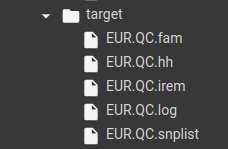

Some files are needed in the QC/target folder for the below processing:

In [47]:
%%bash

cp data/target/EUR* QC/target/

Samples with extreme heterozygosity are typically removed prior to downstream analyses.

This will generate two files 1) EUR.QC.prune.in and 2) EUR.QC.prune.out. All SNPs within EUR.QC.prune.in have a pairwise r2\<0.25

In [ ]:
%%bash
# Perform pruning to remove highly correlated SNPs

plink \
    --bfile QC/target/EUR \
    --keep QC/target/EUR.QC.fam \
    --extract QC/target/EUR.QC.snplist \
    --indep-pairwise 200 50 0.25 \
    --out QC/target/EUR.QC

Heterozygosity rates can then be computed using plink:

In [50]:
%%bash

plink \
    --bfile QC/target/EUR \
    --extract QC/target/EUR.QC.prune.in \
    --keep QC/target/EUR.QC.fam \
    --het \
    --out QC/target/EUR.QC

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to QC/target/EUR.QC.log.
Options in effect:
  --bfile QC/target/EUR
  --extract QC/target/EUR.QC.prune.in
  --het
  --keep QC/target/EUR.QC.fam
  --out QC/target/EUR.QC

12982 MB RAM detected; reserving 6491 MB for main workspace.
551892 variants loaded from .bim file.
503 people (240 males, 263 females) loaded from .fam.
--extract: 268457 variants remaining.
--keep: 489 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 489 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%

commands treat these as missing.


In [51]:
%%bash

cat QC/target/EUR.QC.het | head

      FID       IID       O(HOM)       E(HOM)        N(NM)            F
  HG00096   HG00096       215057    2.148e+05       263228     0.005196
  HG00097   HG00097       214695    2.148e+05       263228     -0.00228
  HG00099   HG00099       214846    2.148e+05       263228    0.0008384
  HG00101   HG00101       214569    2.148e+05       263228    -0.004882
  HG00102   HG00102       215187    2.148e+05       263228     0.007881
  HG00103   HG00103       215264    2.148e+05       263228     0.009471
  HG00105   HG00105       214725    2.148e+05       263228     -0.00166
  HG00107   HG00107       214943    2.148e+05       263228     0.002842
  HG00108   HG00108       214855    2.148e+05       263228     0.001024


In [53]:
%%R
# Read in the EUR.het file, specify it has header
dat <- read.table("QC/target/EUR.QC.het", header=T)

# Calculate the mean
m <- mean(dat$F)

# Calculate the SD
s <- sd(dat$F)

# Get any samples with F coefficient within 3 SD of the population mean
valid <- subset(dat, F <= m+3*s & F >= m-3*s)

# print FID and IID for valid samples
write.table(valid[,c(1,2)], "QC/target/EUR.valid.sample", quote=F, row.names=F)

In [57]:
%%R
head(dat)
dim(dat)

[1] 489   6


In [56]:
%%R
dim(valid)

[1] 487   6
